## Cross Validation Workflow Notebook

#### Sources of information, code and discussions

1. This notebook follows the 5 step process presented in the Chris Deotte "How to compete with GPUs Workshop" [here][1].
2. Triple stratified KFold TFRecords used for image data is explained [here][2].
3. Some code sections have been reused from AgentAuers' notebook [here][3]
4. The advantage of using different input sizes is discussed [here][4]
5. Use external data by changing the variables `INC2019` and `INC2018`.These variables respectively indicate whether to load last year 2019 data and/or year 2018 + 2017 data. These datasets are discussed [here][5]

[1]: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526
[3]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
[4]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147
[5]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164910

####  Initiatialise environment and import necessary libraries

# Initialize Environment

In [3]:
# Use if running in Kaggle environment
#!pip install -q efficientnet >> /dev/null

In [4]:
# import KaggleDatasets if running in Kaggle environment
#from kaggle_datasets import KaggleDatasets

import os, re, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

import efficientnet.tfkeras as efn

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score 

## Configuration

* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 for conistent number of train and validation samples across folds
* IMG_SIZES - These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter. Consider early stopping in Callbacks.
* EFF_NETS - These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF during validation.

In [5]:
ENV = "LOCAL" #or "KAGGLE"

# DEFAULT TO TPU TO ENSURE KAGGLE TPU COMPATIABILITY
# https://www.kaggle.com/docs/tpu
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 45

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [128]*FOLDS

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0]*FOLDS
INC2018 = [0]*FOLDS

# BATCH SIZE AND EPOCHS
# TRY 8, 16, 32, 64, 128, 256. REDUCE IF OOM ERROR, HIGHER FOR TPUS
BATCH_SIZES = [256]*FOLDS
EPOCHS = [20]*FOLDS
EARLY_STOPPING = 0 # Yes:1, No:0

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [0]*FOLDS

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 25

#### Configure environment to use TPUs, Multiple GPUs, Single GPU or just CPU

In [6]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


### Step 1: Preprocess and file handling
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 by changing the `IMG_SIZES` variable in the preceeding code section.

In [7]:
# Load file locations
if ENV == 'KAGGLE':
    #Use GCS if running in Kaggle environment
    PATH = [None]*FOLDS; PATH2 = [None]*FOLDS
    for i,k in enumerate(IMG_SIZES):
        PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
        PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))

    files_train = np.sort(np.array(tf.io.gfile.glob(PATH[0] + '/train*.tfrec')))
    files_test  = np.sort(np.array(tf.io.gfile.glob(PATH[0] + '/test*.tfrec')))

if ENV == 'LOCAL':  
    # Use LDS if running in local environment
    PATH = [None]*FOLDS; PATH2 = [None]*FOLDS
    for i,k in enumerate(IMG_SIZES):
        PATH[i] = f"./siim-isic-melanoma-classification/tfrecords{k}"
        PATH2[i] = f"./siim-isic-melanoma-classification/tfrecords{k}Ext"

    files_train = np.sort(np.array(tf.io.gfile.glob(PATH[0] + '/train*.tfrec')))
    files_test  = np.sort(np.array(tf.io.gfile.glob(PATH[0] + '/test*.tfrec')))    

In [8]:
# Save file locations
if ENV == 'KAGGLE':
    LOG_PATH = ''
    CV_OOF_PREDS_PATH = ''
    CV_TEST_PREDS_PATH = ''
    CV_FOLDS_PATH = ''

if ENV == 'LOCAL':
    LOG_PATH = './logs/'
    CV_OOF_PREDS_PATH = './cv_oof_preds/'
    CV_TEST_PREDS_PATH = './cv_test_preds/'
    CV_FOLDS_PATH = './cv_folds/'

In [9]:
# File handling functions
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [10]:
# Function to stream datasets into model when training, validating and predicting
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

### Step 2: Data Augmentation
This notebook uses rotation, sheer, zoom, shift augmentation. This notebook also uses horizontal flip, saturation, contrast, brightness augmentation similar to last years winner.

In [11]:
# Assign variables
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [12]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

### Step 3: Build Model
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN. Also consider different models to provide diversity of predictions which may benefit the final ensemble.

In [13]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(dim=128, ef=0, v=0):
    inputs = tf.keras.layers.Input(shape=(dim,dim,3))
    
    base = EFNS[ef](input_shape=(dim,dim,3),weights='noisy-student',include_top=False)
    
    x = base(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs,outputs=x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    
    if v:
        model.summary()
    
    return model

# Visualise model in use
build_model(dim=IMG_SIZES[0],ef=EFF_NETS[0],v=1)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________


### Step 4: Training and Cross Validation

#### Training Schedule
Thism is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

In [22]:
TS_CFG = dict(
    lr_start   = 0.000005,
    lr_max     = 0.00000125 * REPLICAS * BATCH_SIZES[0],
    lr_min     = 0.000001,
    lr_ramp_ep = 5,
    lr_sus_ep  = 0,
    lr_decay   = 0.7
    )

In [23]:
def get_lr_callback(ts_cfg, batch_size=8):
    lr_start   = ts_cfg['lr_start']
    lr_max     = ts_cfg['lr_max']
    lr_min     = ts_cfg['lr_min']
    lr_ramp_ep = ts_cfg['lr_ramp_ep']
    lr_sus_ep  = ts_cfg['lr_sus_ep']
    lr_decay   = ts_cfg['lr_decay']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    
    return lr_callback

#### Visualise Training Schedule

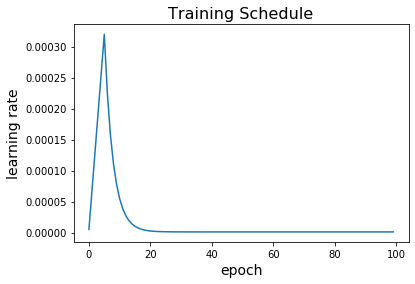

In [24]:
# Quick test and visualisation of learning rate schedule
# Important not to have a high learning rate which would destroy the pre-trained parameters
lr_start   = TS_CFG['lr_start']
lr_max     = TS_CFG['lr_max']
lr_min     = TS_CFG['lr_min']
lr_ramp_ep = TS_CFG['lr_ramp_ep']
lr_sus_ep  = TS_CFG['lr_sus_ep']
lr_decay   = TS_CFG['lr_decay']

def lrfn_sched(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

# Visualise learning rate schedule
rng = [i for i in range(100)]
y = [lrfn_sched(x) for x in rng]
plt.plot(rng, y)
plt.xlabel('epoch', size=14); plt.ylabel('learning rate', size=14)
plt.title('Training Schedule', size=16); plt.show()

#### Train Model
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

In [ ]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []
oof_tar = []
oof_val = []
oof_names = []
oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

best_val_auc_ls = []
best_epoch_val_auc_ls = []

best_val_loss_ls = []
best_epoch_val_loss_ls = []


for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print(f'#### Image Size {IMG_SIZES[fold]} with EfficientNet B{EFF_NETS[fold]} and batch_size {BATCH_SIZES[fold]*REPLICAS}')
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold],v=0)
        
    # CALLBACKS - SAVE BEST MODEL EACH FOLD ALSO UTILISE EARLY STOPPING TO ALLOW MORE EPOCHS
    sv = tf.keras.callbacks.ModelCheckpoint(
        f'{CV_FOLDS_PATH}EB{EFF_NETS[0]}-{IMG_SIZES[0]}-fold-{fold}.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
    
    if EARLY_STOPPING:
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=VERBOSE, mode='auto')
        callback_list = [sv,es,get_lr_callback(TS_CFG, BATCH_SIZES[fold])]
    else:
        callback_list = [sv,get_lr_callback(TS_CFG, BATCH_SIZES[fold])]
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
        epochs=EPOCHS[fold],
        callbacks = callback_list, 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), #class_weight = {0:1,1:2},
        verbose=VERBOSE
    )
    
    # DETERMINE BEST SCORES AND EPOCHS
    val_auc_ls = history.history['val_auc']
    val_loss_ls = history.history['val_loss']
    
    best_val_auc = max(val_auc_ls)
    best_val_loss = min(val_loss_ls)
    best_val_auc_ls.append(best_val_auc)
    best_val_loss_ls.append(best_val_loss)
    
    opt_epoch_auc = val_auc_ls.index(best_val_auc)
    opt_epoch_loss = val_loss_ls.index(best_val_loss)
    best_epoch_val_auc_ls.append(opt_epoch_auc)
    best_epoch_val_loss_ls.append(opt_epoch_loss)
    
    #RELOAD BEST WEIGHTS AT BEST EPOCH
    print('Loading best model...')
    model.load_weights(f'{CV_FOLDS_PATH}EB{EFF_NETS[0]}-{IMG_SIZES[0]}-fold-{fold}.h5')
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    COMPLETED_EPOCHS = len(history.history['loss'])
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(COMPLETED_EPOCHS),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(COMPLETED_EPOCHS),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] )
        y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4')
        plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(COMPLETED_EPOCHS),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(COMPLETED_EPOCHS),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] )
        y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728')
        plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show()  

#########################
#### FOLD 1
#### Image Size 128 with EfficientNet B0 and batch_size 256
#########################
Training...
Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 0.5998 - auc: 0.5229
Epoch 00001: val_loss improved from inf to 0.50382, saving model to ./cv_folds/EB0-128-fold-0.h5
102/102 [==============================] - 39s 385ms/step - loss: 0.5998 - auc: 0.5229 - val_loss: 0.5038 - val_auc: 0.4057
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.2450 - auc: 0.5655
Epoch 00002: val_loss improved from 0.50382 to 0.17842, saving model to ./cv_folds/EB0-128-fold-0.h5
102/102 [==============================] - 39s 383ms/step - loss: 0.2450 - auc: 0.5655 - val_loss: 0.1784 - val_auc: 0.5686
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.1719 - auc: 0.7884
Epoch 00003: val_loss improved from 0.17842 to 0.17223, saving model to ./cv_folds/EB0-128-fold-0.h5
102/102 [==============================] - 3

#### Show the optimal characteristics from CV

In [ ]:
best_epoch_val_auc_mean = np.mean(np.array(best_epoch_val_auc_ls), axis=0)
best_epoch_val_loss_mean = np.mean(np.array(best_epoch_val_loss_ls), axis=0)

print("The best epoch value for AUC over the cv is: ",best_epoch_val_auc_mean)
print("The best epoch value for loss over the cv is: ",best_epoch_val_loss_mean)

In [ ]:
cv_val_auc_mean = np.mean(np.array(best_val_auc_ls), axis=0)
cv_val_auc_std = np.std(np.array(best_val_auc_ls), axis=0)
cv_val_loss_mean = np.mean(np.array(best_val_loss_ls), axis=0)

print(f"The mean AUC score across CV folds is {cv_val_auc_mean:.2f} and the standard deviation is {cv_val_auc_std:.2%}")

#### Calculate OOF AUC
The OOF (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the OOF to determine what are the best weights to blend your models with. Choose weights that maximize OOF CV score when used to blend OOF. Then use those same weights to blend your test predictions.

In [ ]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred)
true = np.concatenate(oof_tar);
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv(f'{CV_OOF_PREDS_PATH}EB{EFF_NETS[0]}-{IMG_SIZES[0]}-oof.csv',index=False)
df_oof.head()

### Step 5: Post process
There are ways to modify predictions based on patient information to increase CV LB. You can experiment with that here on your OOF.

### Log values from the cross validation process

In [ ]:
if ENV == 'LOCAL':
    log_df = pd.read_csv('./logs/experiment_log.csv')
    headers = list(log_df.columns.values)
    
if ENV == 'KAGGLE':
    headers = ['Image Size',
             'Model',
             'Batch Size',
             'Replicas',
             'Total Batch Size',
             'TTA Loops',
             'CV Folds',
             'Mean CV AUC',
             'Std CV AUC',
             'OOF AUC with TTA',
             'Mean CV Loss',
             'Total Epochs',
             'Best AUC Epoch',
             'Best Loss Epoch',
             'Kaggle LB AUC']
    log_df = pd.DataFrame(columns = headers)

In [ ]:
log_items = [IMG_SIZES[0],
            str(f"EFNB{EFF_NETS[0]}"),
            BATCH_SIZES[0],
            REPLICAS,
            BATCH_SIZES[0] * REPLICAS,
            TTA,
            FOLDS,
            cv_val_auc_mean,
            cv_val_auc_std, 
            auc,
            cv_val_loss_mean,
            EPOCHS[0],
            best_epoch_val_auc_mean,
            best_epoch_val_loss_mean,
            0.00]

In [ ]:
for n in range(len(headers)):
    print(headers[n]+":", log_items[n])
    
log_data = pd.DataFrame([log_items], columns=headers)
log_df = log_df.append(log_data)
log_df.sort_values(by=['Model','Image Size'], inplace=True)
log_df.to_csv(f'{LOG_PATH}experiment_log.csv', index=False)
log_df.tail(20)

### Prepare Kaggle File

In [ ]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [ ]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv(f'{CV_TEST_PREDS_PATH}EB{EFF_NETS[0]}-{IMG_SIZES[0]}-{FOLDS}FCV-submission.csv', index=False)
submission.head()

In [ ]:
plt.hist(submission.target,bins=100)
plt.show()